c:\Users\Akash Kalakonda\Desktop\sales_forecasting\src\load_data.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


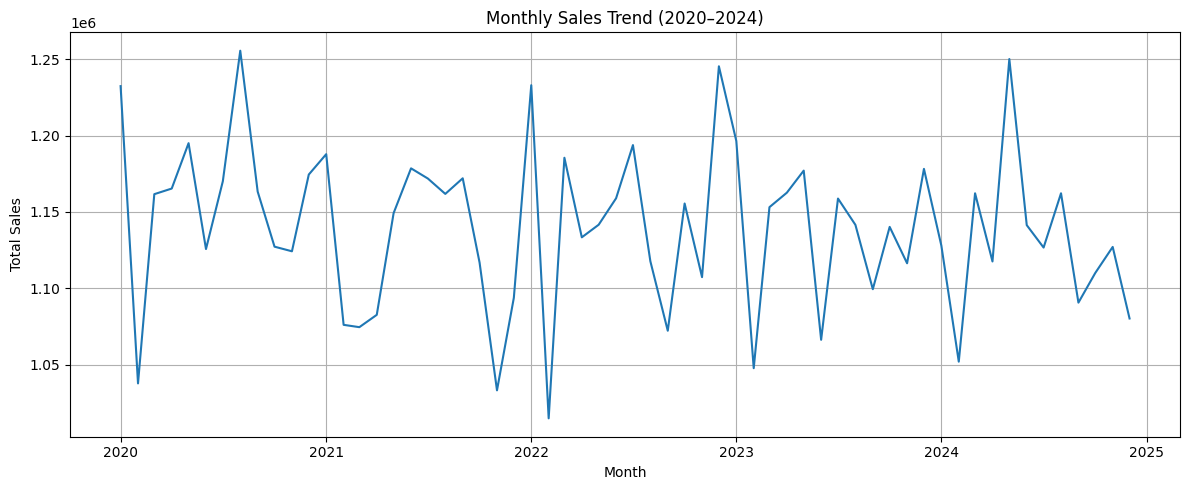

In [1]:
import matplotlib.pyplot as plt
from load_data import load_monthly_sales

df = load_monthly_sales()

plt.figure(figsize=(12, 5))
plt.plot(df["month"], df["total_sales"])
plt.title("Monthly Sales Trend (2020–2024)")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
df = load_monthly_sales()
df.head()


c:\Users\Akash Kalakonda\Desktop\sales_forecasting\src\load_data.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,month,total_sales
0,2020-01-01,1232359.81
1,2020-02-01,1037776.36
2,2020-03-01,1161649.95
3,2020-04-01,1165324.80
4,2020-05-01,1195031.29


Seasonal Decomposition

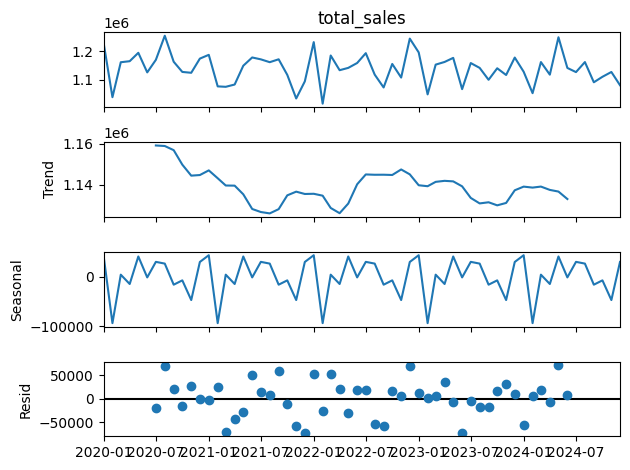

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(
    df.set_index("month")["total_sales"],
    model="additive",
    period=12
)

decomp.plot()
plt.show()


ADF Stationary Test

In [4]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df["total_sales"])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -8.788131903418009
p-value: 2.2789864687680753e-14


Differencing + ADF Again

In [5]:
df["sales_diff"] = df["total_sales"].diff()

adf_diff = adfuller(df["sales_diff"].dropna())

print("ADF Statistic (diff):", adf_diff[0])
print("p-value (diff):", adf_diff[1])


ADF Statistic (diff): -4.958710565390718
p-value (diff): 2.677070692712735e-05


INTERPRETING YOUR ADF RESULTS (CRITICAL)
1️⃣ Original series
ADF p-value ≈ 2.28e-14
This is ≪ 0.05                                                                 
2️⃣ Differenced series
ADF p-value ≈ 2.67e-05
Also ≪ 0.05
✅ Differenced series is stationary as well
It means:
Trend is stable
Variance is controlled
ARIMA will behave nicely

ADF test indicated stationarity in the original series, so I used d=0 in ARIMA.

## ARIMA Modeling
Train/Test Split (VERY IMPORTANT)
We will:
Train on first 54 months
Test on last 6 months

In [6]:
train = df.iloc[:-6]
test = df.iloc[-6:]

print("Train size:", train.shape)
print("Test size:", test.shape)


Train size: (54, 3)
Test size: (6, 3)


Fit the ARIMA model

In [7]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(
    train["total_sales"],
    order=(1, 0, 1)
)

model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:            total_sales   No. Observations:                   54
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -664.265
Date:                Tue, 06 Jan 2026   AIC                           1336.529
Time:                        10:49:17   BIC                           1344.485
Sample:                             0   HQIC                          1339.598
                                 - 54                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.142e+06   2686.987    425.096      0.000    1.14e+06    1.15e+06
ar.L1          0.7561      0.189      3.997      0.000       0.385       1.127
ma.L1         -0.9324      0.128     -7.279      0.0

c:\Users\Akash Kalakonda\.conda\envs\sales_venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast on Test Data

In [8]:
forecast = model_fit.forecast(steps=6)

forecast = forecast.values
actual = test["total_sales"].values


Performance Metrics

In [9]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(actual, forecast)
accuracy = (1 - mape) * 100

print("MAPE:", mape)
print("Forecast Accuracy (%):", accuracy)


ModuleNotFoundError: No module named 'sklearn'

In [10]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(actual, forecast)
accuracy = (1 - mape) * 100

print("MAPE:", mape)
print("Forecast Accuracy (%):", accuracy)


MAPE: 0.03029764659733074
Forecast Accuracy (%): 96.97023534026692


Visualize Actual vs Forecast

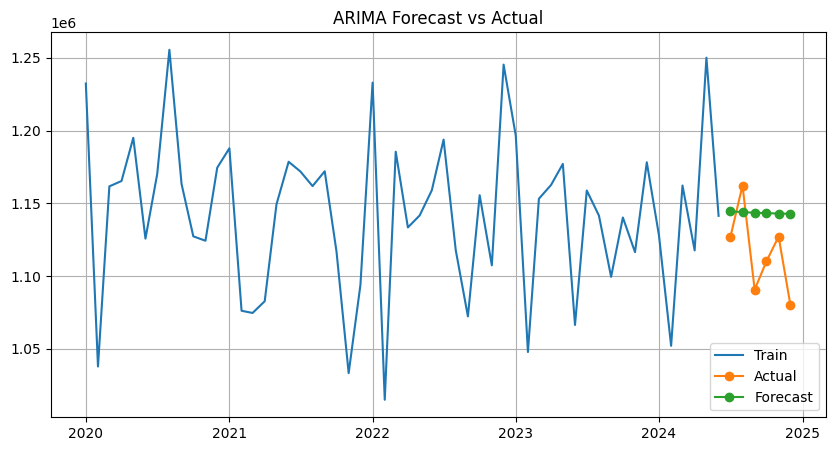

In [11]:
plt.figure(figsize=(10,5))
plt.plot(train["month"], train["total_sales"], label="Train")
plt.plot(test["month"], actual, label="Actual", marker="o")
plt.plot(test["month"], forecast, label="Forecast", marker="o")
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()


Retrain ARIMA on Full Data

In [12]:
from statsmodels.tsa.arima.model import ARIMA

final_model = ARIMA(
    df["total_sales"],
    order=(1, 0, 1)
)

final_model_fit = final_model.fit()


Forecast Next 6 Months

In [15]:
import pandas as pd

future_forecast = final_model_fit.forecast(steps=6)

future_months = pd.date_range(
    start=df["month"].iloc[-1] + pd.offsets.MonthBegin(1),
    periods=6,
    freq="MS"
)

forecast_df = pd.DataFrame({
    "month": future_months,
    "forecast_sales": future_forecast.values
})

forecast_df


,month,forecast_sales
0,2025-01-01,1.165697e+06
1,2025-02-01,1.159865e+06
2,2025-03-01,1.155337e+06
3,2025-04-01,1.151822e+06
4,2025-05-01,1.149093e+06
5,2025-06-01,1.146974e+06


forecast sales for next 6 months

In [16]:
forecast_df["forecast_sales"] = forecast_df["forecast_sales"].round(0).astype(int)
forecast_df


,month,forecast_sales
0,2025-01-01,1165697
1,2025-02-01,1159865
2,2025-03-01,1155337
3,2025-04-01,1151822
4,2025-05-01,1149093
5,2025-06-01,1146974
